Number of daily returns: 2007

=== Summary of daily losses (L1 = -log returns) ===
Mean (mu):        -0.000962
Std dev (sigma):  0.019402
Min (best gain):  -0.1426
Max (worst loss): 0.1377

=== 1-DAY VaR & ES (losses on log-return scale) ===

1-day VaR and ES (as % loss of portfolio):
       VaR_hist  ES_hist  VaR_norm  ES_norm   VaR_t    ES_t    df_t
99%      5.1058   7.2090    4.4173   5.0748  5.2736  7.8911  3.2944
97.5%    3.9276   5.5862    3.7065   4.4396  3.7342  5.7722  3.2944

Number of non-overlapping 10-day returns: 200

=== 10-DAY VaR & ES ===
Historical (non-overlapping 10-day returns) vs Normal with sqrt-of-time scaling

10-day VaR and ES (as % loss of portfolio):
       VaR_hist_10d  ES_hist_10d  VaR_norm_10d_scaled  ES_norm_10d_scaled
99%         17.9652      22.5654              13.3111             15.3902
97.5%       12.6455      18.3677              11.0632             13.3814

=== Comparison: 10-day hist VaR vs sqrt(10) * 1-day hist VaR ===
99%: ratio ≈ 1.113 (10-da

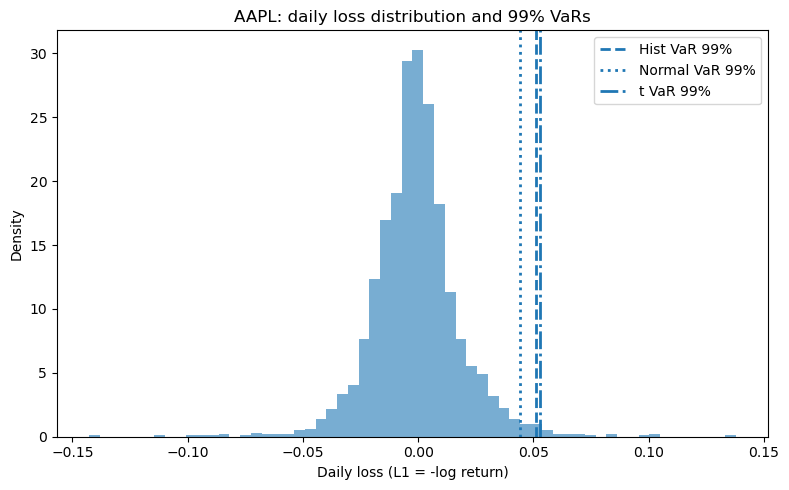

In [11]:
"""
Project 2 – Basel-style: 1-day → 10-day VaR & ES from market data

This script:

- Downloads 5–10 years of daily prices for a chosen ticker (default: AAPL)
- Computes daily log-returns
- Computes 1-day VaR & ES at 99% and 97.5% using:
    * Historical simulation
    * Parametric Normal
    * Parametric Student-t
- Extends to 10-day horizon:
    * Regulatory style: Normal VaR/ES with square-root-of-time scaling
    * QRM style: historical VaR/ES on non-overlapping 10-day returns
- Plots the daily loss distribution with VaR lines.

All VaR/ES numbers are reported as percentage loss (positive = loss).
"""

from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from scipy import stats
import yfinance as yf
import matplotlib.pyplot as plt


# -------------------------------------------------------------------
# Data helpers
# -------------------------------------------------------------------

def download_price_data(ticker: str = "AAPL", years: int = 8) -> pd.Series:
    """
    Download adjusted close prices for the given ticker and years of history.
    Uses Yahoo Finance via yfinance.

    Returns a *single* price Series. If multiple columns exist, takes the first.
    """
    end = datetime.today()
    start = end - timedelta(days=365 * years)

    data = yf.download(ticker, start=start, end=end,
                       auto_adjust=True, progress=False)

    if data.empty:
        raise ValueError("No data downloaded. Check ticker or date range.")

    # Prefer Adj Close if present
    if "Adj Close" in data.columns:
        prices = data["Adj Close"]
    else:
        prices = data["Close"]

    # If still a DataFrame (e.g. multiple tickers), use the first column
    if isinstance(prices, pd.DataFrame):
        if prices.shape[1] > 1:
            print("Multiple price series detected. Using the first one:", prices.columns[0])
        prices = prices.iloc[:, 0]

    prices = prices.dropna()

    if prices.empty:
        raise ValueError("Price series is empty after dropna. Check data.")

    return prices


def compute_log_returns(prices: pd.Series) -> pd.Series:
    """
    Compute daily log-returns r_t = ln(P_t / P_{t-1}).
    Ensures the result is a 1D Series.
    """
    # If prices came as DataFrame somehow, reduce to first column
    if isinstance(prices, pd.DataFrame):
        if prices.shape[1] > 1:
            print("Multiple price series detected in compute_log_returns. Using first column.")
        prices = prices.iloc[:, 0]

    returns = np.log(prices / prices.shift(1))
    returns = returns.dropna()

    # Ensure returns is a Series
    if isinstance(returns, pd.DataFrame):
        if returns.shape[1] > 1:
            print("Multiple return series detected. Using first column.")
        returns = returns.iloc[:, 0]

    return returns


# -------------------------------------------------------------------
# VaR & ES helper functions
# -------------------------------------------------------------------

def historical_var_es(losses: pd.Series, alpha: float):
    """
    Historical (empirical) VaR & ES for loss series L (positive = loss).

    VaR_alpha  = empirical alpha-quantile of losses.
    ES_alpha   = mean loss conditional on loss >= VaR_alpha.
    """
    losses = pd.Series(losses).dropna()
    var = losses.quantile(alpha)
    es = losses[losses >= var].mean()
    return var, es


def normal_parametric_var_es(losses: pd.Series, alpha: float):
    """
    Parametric Normal VaR & ES for loss series L.

    Assume L ~ N(mu, sigma^2).

    VaR_alpha = mu + z_alpha * sigma
    ES_alpha  = mu + sigma * phi(z_alpha) / (1 - alpha)

    Returns VaR, ES, mu, sigma.
    """
    losses = pd.Series(losses).dropna()
    mu = losses.mean()
    sigma = losses.std(ddof=1)

    z = stats.norm.ppf(alpha)
    var = mu + z * sigma
    es = mu + sigma * stats.norm.pdf(z) / (1 - alpha)

    return var, es, mu, sigma


def t_parametric_var_es(losses: pd.Series, alpha: float):
    """
    Parametric Student-t VaR & ES for loss series L.

    Fit L ~ t(df, loc=mu, scale=s).

    VaR_alpha = t_ppf(alpha; df, loc, scale)

    ES_alpha formula for losses L ~ generalized Student-t (df, mu, sigma):
        ES_alpha(L) = mu + sigma * ((df + t_alpha^2) / (df - 1)) * tau(t_alpha) / (1 - alpha)

    where
        t_alpha = standard t-quantile (df)
        tau(.)  = standard t pdf (df)

    Returns VaR, ES, df, loc, scale.
    """
    losses = pd.Series(losses).dropna()

    # Fit df, location (mu), and scale (sigma)
    df, loc, scale = stats.t.fit(losses)

    # VaR for general t
    var = stats.t.ppf(alpha, df, loc=loc, scale=scale)

    # ES using closed-form formula for standard t, then scale
    t_alpha = stats.t.ppf(alpha, df)          # standard t quantile
    pdf_t_alpha = stats.t.pdf(t_alpha, df)    # standard t pdf

    es = loc + scale * ((df + t_alpha**2) / (df - 1)) * pdf_t_alpha / (1 - alpha)

    return var, es, df, loc, scale


def normal_scaled_var_es(mu1: float, sigma1: float, alpha: float,
                         horizon: int = 10):
    """
    Normal parametric VaR & ES scaled to a longer horizon with square-root-of-time.

    Daily losses: L_1 ~ N(mu1, sigma1^2)
    Horizon H:   L_H = sum_{i=1}^H L_1i ~ N(H * mu1, H * sigma1^2)

    So:
      mu_H    = H * mu1
      sigma_H = sqrt(H) * sigma1

      VaR_H = mu_H + z_alpha * sigma_H
      ES_H  = mu_H + sigma_H * phi(z_alpha) / (1 - alpha)

    Returns horizon VaR and ES.
    """
    z = stats.norm.ppf(alpha)
    mu_h = horizon * mu1
    sigma_h = np.sqrt(horizon) * sigma1

    var_h = mu_h + z * sigma_h
    es_h = mu_h + sigma_h * stats.norm.pdf(z) / (1 - alpha)

    return var_h, es_h


# -------------------------------------------------------------------
# Plotting helper
# -------------------------------------------------------------------

def plot_loss_distribution_with_vars(losses: pd.Series,
                                     df_1d: pd.DataFrame,
                                     ticker: str,
                                     alpha_label: str = "99%"):
    """
    Plot histogram of daily losses with vertical lines for historical,
    Normal, and t VaR at the selected confidence level (alpha_label).

    alpha_label must match the index label in df_1d, e.g. "99%" or "97.5%".
    """
    if alpha_label not in df_1d.index:
        raise ValueError(f"alpha_label '{alpha_label}' not found in df_1d.index {list(df_1d.index)}")

    var_hist = df_1d.loc[alpha_label, "VaR_hist"]
    var_norm = df_1d.loc[alpha_label, "VaR_norm"]
    var_t = df_1d.loc[alpha_label, "VaR_t"]

    plt.figure(figsize=(8, 5))
    plt.hist(losses, bins=60, density=True, alpha=0.6)
    plt.axvline(var_hist, linestyle="--", linewidth=2, label=f"Hist VaR {alpha_label}")
    plt.axvline(var_norm, linestyle=":", linewidth=2, label=f"Normal VaR {alpha_label}")
    plt.axvline(var_t, linestyle="-.", linewidth=2, label=f"t VaR {alpha_label}")

    plt.xlabel("Daily loss (L1 = -log return)")
    plt.ylabel("Density")
    plt.title(f"{ticker}: daily loss distribution and {alpha_label} VaRs")
    plt.legend()
    plt.tight_layout()
    plt.show()


# -------------------------------------------------------------------
# Main analysis
# -------------------------------------------------------------------

def run_analysis(ticker: str = "AAPL", years: int = 8):
    # Confidence levels
    alphas = [0.99, 0.975]  # 99% (Basel II.5) and 97.5% (FRTB ES)

    print(f"Downloading data for {ticker} over the last {years} years...")
    prices = download_price_data(ticker, years)
    returns = compute_log_returns(prices)

    print(f"Number of daily returns: {len(returns)}")

    # Define losses: positive values represent losses
    L1 = -returns

    # Basic summary of daily losses
    print("\n=== Summary of daily losses (L1 = -log returns) ===")
    mu_L1 = float(L1.mean())
    sigma_L1 = float(L1.std(ddof=1))
    print(f"Mean (mu):        {mu_L1:.6f}")
    print(f"Std dev (sigma):  {sigma_L1:.6f}")
    print(f"Min (best gain):  {float(L1.min()):.4f}")
    print(f"Max (worst loss): {float(L1.max()):.4f}")

    # ---------------------------------------------------------------
    # 1-day VaR & ES
    # ---------------------------------------------------------------
    rows_1d = []
    index_labels = []

    print("\n=== 1-DAY VaR & ES (losses on log-return scale) ===")

    for alpha in alphas:
        # Nice human labels for the index
        if alpha == 0.99:
            label = "99%"
        elif alpha == 0.975:
            label = "97.5%"
        else:
            label = f"{alpha * 100:.1f}%"

        # Historical
        var_hist, es_hist = historical_var_es(L1, alpha)

        # Parametric Normal
        var_norm, es_norm, mu1, sigma1 = normal_parametric_var_es(L1, alpha)

        # Parametric Student-t
        var_t, es_t, df_t, loc_t, scale_t = t_parametric_var_es(L1, alpha)

        rows_1d.append({
            "VaR_hist": var_hist,
            "ES_hist": es_hist,
            "VaR_norm": var_norm,
            "ES_norm": es_norm,
            "VaR_t": var_t,
            "ES_t": es_t,
            "df_t": df_t,
        })
        index_labels.append(label)

    df_1d = pd.DataFrame(rows_1d, index=index_labels)

    # Convert VaR/ES columns to percentages (≈ simple % loss)
    risk_cols_1d = ["VaR_hist", "ES_hist", "VaR_norm", "ES_norm", "VaR_t", "ES_t"]
    df_1d_pct = df_1d.copy()
    df_1d_pct[risk_cols_1d] = df_1d_pct[risk_cols_1d] * 100

    print("\n1-day VaR and ES (as % loss of portfolio):")
    print(df_1d_pct.round(4))

    # ---------------------------------------------------------------
    # 10-day horizon
    # ---------------------------------------------------------------
    window = 10

    # QRM style: 10-day log-returns via rolling sum, then take non-overlapping windows
    r_10d = returns.rolling(window=window).sum().dropna()
    if isinstance(r_10d, pd.DataFrame):
        if r_10d.shape[1] > 1:
            print("Multiple 10-day return series detected. Using first column.")
        r_10d = r_10d.iloc[:, 0]

    r_10d_nonoverlap = r_10d.iloc[::window]  # every 10th
    L10_hist = -r_10d_nonoverlap

    print(f"\nNumber of non-overlapping {window}-day returns: {len(r_10d_nonoverlap)}")

    rows_10d = []

    for alpha in alphas:
        if alpha == 0.99:
            label = "99%"
        elif alpha == 0.975:
            label = "97.5%"
        else:
            label = f"{alpha * 100:.1f}%"

        # Historical 10-day VaR/ES (non-overlapping returns)
        var10_hist, es10_hist = historical_var_es(L10_hist, alpha)

        # Normal 10-day VaR/ES via square-root-of-time scaling
        var10_norm_scaled, es10_norm_scaled = normal_scaled_var_es(
            mu_L1, sigma_L1, alpha, horizon=window
        )

        rows_10d.append({
            "VaR_hist_10d": var10_hist,
            "ES_hist_10d": es10_hist,
            "VaR_norm_10d_scaled": var10_norm_scaled,
            "ES_norm_10d_scaled": es10_norm_scaled,
        })

    df_10d = pd.DataFrame(rows_10d, index=index_labels)
    df_10d_pct = df_10d.copy()
    df_10d_pct[df_10d_pct.columns] = df_10d_pct[df_10d_pct.columns] * 100

    print("\n=== 10-DAY VaR & ES ===")
    print("Historical (non-overlapping 10-day returns) vs Normal with sqrt-of-time scaling")
    print("\n10-day VaR and ES (as % loss of portfolio):")
    print(df_10d_pct.round(4))

    # ---------------------------------------------------------------
    # Comparison of scaling: does sqrt(10) work?
    # ---------------------------------------------------------------
    print("\n=== Comparison: 10-day hist VaR vs sqrt(10) * 1-day hist VaR ===")
    for alpha_label in df_1d_pct.index:
        var1 = df_1d_pct.loc[alpha_label, "VaR_hist"]
        var10 = df_10d_pct.loc[alpha_label, "VaR_hist_10d"]
        ratio = var10 / (var1 * np.sqrt(window))
        print(f"{alpha_label}: ratio ≈ {ratio:.3f} "
              f"(10-day_hist_VaR / (sqrt(10) * 1-day_hist_VaR))")

    # ---------------------------------------------------------------
    # Discussion prompts (printed)
    # ---------------------------------------------------------------
    print("\n--- Questions for discussion ---")
    print("1. Compare 1-day vs 10-day VaR/ES. Does 10-day risk scale roughly with sqrt(10)?")
    print("2. Compare historical vs Normal vs Student-t for 1-day. Which is more conservative?")
    print("3. For 10-day, compare historical VaR/ES vs Normal scaled VaR/ES.")
    print("   - When is square-root-of-time scaling likely to under- or over-estimate risk?")
    print("4. At each confidence level, is ES significantly larger than VaR?")
    print("   - Why might regulators prefer ES over VaR (especially under FRTB)?")

    # Return objects so we can plot outside
    return L1, df_1d, df_10d


# -------------------------------------------------------------------
# Run (edit these lines for your class or notebook)
# -------------------------------------------------------------------

TICKER = "AAPL"   # e.g. "AAPL", "SPY", "^STOXX50E"
YEARS = 8         # e.g. 5–10 years of history

if __name__ == "__main__":
    L1, df_1d, df_10d = run_analysis(TICKER, YEARS)
    # Example plot: daily loss distribution with 99% VaRs
    plot_loss_distribution_with_vars(L1, df_1d, TICKER, alpha_label="99%")


In [13]:
"""
Project 3 – "Stressed VaR" and crisis sub-sample

Goal:
    Illustrate stressed calibration, as in Basel II.5/III.

What this script does:

1. Downloads price data for a single asset (default: S&P 500 ETF 'SPY').
2. Computes daily log-returns.
3. Builds non-overlapping 10-day log-returns.
4. Splits the sample into:
    - A "calm" window (default: 2013-01-01 to 2019-12-31)
    - A "stress" window (default: 2008-01-01 to 2009-12-31)
5. For each window, computes:
    - 99% 10-day VaR (historical)
    - 97.5% 10-day ES (historical)
6. Prints a comparison table and stress / calm ratios.

All VaR/ES numbers are reported as percentage loss (positive = loss).

You can change:
    - TICKER
    - CALM_START, CALM_END
    - STRESS_START, STRESS_END
"""

from datetime import datetime
import numpy as np
import pandas as pd
import yfinance as yf


# -------------------------------------------------------------
# Helpers: data, returns, and risk measures
# -------------------------------------------------------------

def download_price_data(ticker: str,
                        start_date: str,
                        end_date: str) -> pd.Series:
    """
    Download adjusted close prices for given ticker and date range.
    Returns a *single* price series.
    """
    data = yf.download(ticker,
                       start=start_date,
                       end=end_date,
                       auto_adjust=True,
                       progress=False)

    if data.empty:
        raise ValueError("No data downloaded. Check ticker or date range.")

    # Prefer Adj Close if present, otherwise use Close
    if "Adj Close" in data.columns:
        prices = data["Adj Close"]
    else:
        prices = data["Close"]

    # Just in case prices is a DataFrame (multi-ticker), take first column
    if isinstance(prices, pd.DataFrame):
        if prices.shape[1] > 1:
            print("Multiple price series detected. Using the first one:", prices.columns[0])
        prices = prices.iloc[:, 0]

    prices = prices.dropna()

    if prices.empty:
        raise ValueError("Price series empty after dropna().")

    return prices


def compute_log_returns(prices: pd.Series) -> pd.Series:
    """
    Compute daily log-returns r_t = ln(P_t / P_{t-1}).
    Ensures output is a 1D Series.
    """
    if isinstance(prices, pd.DataFrame):
        prices = prices.iloc[:, 0]

    returns = np.log(prices / prices.shift(1))
    returns = returns.dropna()

    if isinstance(returns, pd.DataFrame):
        returns = returns.iloc[:, 0]

    return returns


def make_10day_nonoverlapping_returns(daily_returns: pd.Series,
                                      window: int = 10) -> pd.Series:
    """
    Build non-overlapping 10-day log-returns from daily log-returns.

    Steps:
      - rolling(window).sum() to get 10-day log returns
      - drop NaNs
      - take every `window`th observation to avoid overlap
    """
    r_10d = daily_returns.rolling(window=window).sum().dropna()

    if isinstance(r_10d, pd.DataFrame):
        r_10d = r_10d.iloc[:, 0]

    # Non-overlapping: take every `window`th window
    r_10d_nonoverlap = r_10d.iloc[::window]
    return r_10d_nonoverlap


def historical_var_es(losses: pd.Series, alpha: float):
    """
    Historical VaR & ES for a loss series.

    losses : Series of losses (positive = loss)
    alpha  : confidence level (e.g. 0.99 for 99% VaR/ES)

    VaR_alpha  = empirical alpha-quantile of losses
    ES_alpha   = mean of losses >= VaR_alpha
    """
    losses = pd.Series(losses).dropna()
    var = losses.quantile(alpha)
    es = losses[losses >= var].mean()
    return var, es


# -------------------------------------------------------------
# Main logic for Project 3
# -------------------------------------------------------------

def run_stressed_var_analysis(
    ticker: str = "SPY",
    calm_start: str = "2013-01-01",
    calm_end: str = "2019-12-31",
    stress_start: str = "2008-01-01",
    stress_end: str = "2009-12-31",
    window: int = 10,
):
    """
    Run stressed VaR analysis for the given ticker and periods.

    Returns a DataFrame with 10-day 99% VaR and 97.5% ES
    for calm and stressed windows.
    """
    # Determine overall download window: min(start), max(end)
    global_start = min(calm_start, stress_start)
    global_end = max(calm_end, stress_end)

    print(f"Downloading data for {ticker} from {global_start} to {global_end}...")
    prices = download_price_data(ticker, global_start, global_end)
    daily_returns = compute_log_returns(prices)

    print(f"Total daily returns available: {len(daily_returns)}")
    print(f"From {daily_returns.index.min().date()} to {daily_returns.index.max().date()}")

    # -----------------------------
    # Build 10-day non-overlapping returns for each sub-period
    # -----------------------------
    # Calm period
    calm_returns = daily_returns.loc[calm_start:calm_end]
    r10_calm = make_10day_nonoverlapping_returns(calm_returns, window=window)
    L10_calm = -r10_calm  # losses

    # Stress period
    stress_returns = daily_returns.loc[stress_start:stress_end]
    r10_stress = make_10day_nonoverlapping_returns(stress_returns, window=window)
    L10_stress = -r10_stress  # losses

    print(f"\nCalm period:   {calm_start} to {calm_end}")
    print(f"  10-day observations (non-overlapping): {len(L10_calm)}")
    print(f"Stress period: {stress_start} to {stress_end}")
    print(f"  10-day observations (non-overlapping): {len(L10_stress)}")

    if len(L10_calm) < 20 or len(L10_stress) < 20:
        print("\nWARNING: One of the periods has very few 10-day observations.")
        print("         Results may be unstable. Consider lengthening the windows.")

    # -----------------------------
    # Compute VaR/ES
    # -----------------------------
    alpha_var = 0.99   # 99% VaR
    alpha_es = 0.975   # 97.5% ES

    # Calm
    calm_var_99, _ = historical_var_es(L10_calm, alpha_var)
    _, calm_es_975 = historical_var_es(L10_calm, alpha_es)

    # Stress
    stress_var_99, _ = historical_var_es(L10_stress, alpha_var)
    _, stress_es_975 = historical_var_es(L10_stress, alpha_es)

    # Collect in DataFrame, convert to % losses
    data = {
        "99% 10d VaR (%)": [
            calm_var_99 * 100,
            stress_var_99 * 100,
        ],
        "97.5% 10d ES (%)": [
            calm_es_975 * 100,
            stress_es_975 * 100,
        ],
    }
    index = ["Calm period", "Stress period"]
    results = pd.DataFrame(data, index=index)

    # Ratios
    var_ratio = stress_var_99 / calm_var_99 if calm_var_99 != 0 else np.nan
    es_ratio = stress_es_975 / calm_es_975 if calm_es_975 != 0 else np.nan

    print("\n=== 10-DAY STRESSED VS CALM RISK MEASURES (HISTORICAL) ===")
    print(results.round(4))

    print("\nMultipliers (Stress / Calm):")
    print(f"  99% 10-day VaR multiplier:   {var_ratio:.2f}x")
    print(f"  97.5% 10-day ES multiplier:  {es_ratio:.2f}x")

    print("\n--- Discussion prompts ---")
    print("1. How much larger is 99% 10-day VaR in the stress period vs calm?")
    print("2. How much larger is 97.5% 10-day ES?")
    print("3. Why might regulators want capital based on stressed conditions?")
    print("4. How does this relate to procyclicality:")
    print("   - In calm times, recent data suggests low risk -> low capital.")
    print("   - In crisis times, risk (and capital) would suddenly jump.")

    return results, L10_calm, L10_stress


# -------------------------------------------------------------
# Example usage (edit for your course / notebook)
# -------------------------------------------------------------

# Default example:
#   ticker = "SPY" (S&P 500 ETF)
#   calm   = 2013–2019
#   stress = 2008–2009 (GFC)
TICKER = "SPY"
CALM_START = "2013-01-01"
CALM_END = "2019-12-31"
STRESS_START = "2008-01-01"
STRESS_END = "2009-12-31"

if __name__ == "__main__":
    results, L10_calm, L10_stress = run_stressed_var_analysis(
        ticker=TICKER,
        calm_start=CALM_START,
        calm_end=CALM_END,
        stress_start=STRESS_START,
        stress_end=STRESS_END,
        window=10,
    )


Total daily returns available: 3019
From 2008-01-03 to 2019-12-30

Calm period:   2013-01-01 to 2019-12-31
  10-day observations (non-overlapping): 176
Stress period: 2008-01-01 to 2009-12-31
  10-day observations (non-overlapping): 50

=== 10-DAY STRESSED VS CALM RISK MEASURES (HISTORICAL) ===
               99% 10d VaR (%)  97.5% 10d ES (%)
Calm period             4.8753            4.8172
Stress period          13.9078           13.8318

Multipliers (Stress / Calm):
  99% 10-day VaR multiplier:   2.85x
  97.5% 10-day ES multiplier:  2.87x

--- Discussion prompts ---
1. How much larger is 99% 10-day VaR in the stress period vs calm?
2. How much larger is 97.5% 10-day ES?
3. Why might regulators want capital based on stressed conditions?
4. How does this relate to procyclicality:
   - In calm times, recent data suggests low risk -> low capital.
   - In crisis times, risk (and capital) would suddenly jump.


In [15]:
results, L10_calm, L10_stress = run_stressed_var_analysis(
    ticker="SPY",
    calm_start="2013-01-01",
    calm_end="2019-12-31",
    stress_start="2008-01-01",
    stress_end="2009-12-31",
    window=10,
)
results


Total daily returns available: 3019
From 2008-01-03 to 2019-12-30

Calm period:   2013-01-01 to 2019-12-31
  10-day observations (non-overlapping): 176
Stress period: 2008-01-01 to 2009-12-31
  10-day observations (non-overlapping): 50

=== 10-DAY STRESSED VS CALM RISK MEASURES (HISTORICAL) ===
               99% 10d VaR (%)  97.5% 10d ES (%)
Calm period             4.8753            4.8172
Stress period          13.9078           13.8318

Multipliers (Stress / Calm):
  99% 10-day VaR multiplier:   2.85x
  97.5% 10-day ES multiplier:  2.87x

--- Discussion prompts ---
1. How much larger is 99% 10-day VaR in the stress period vs calm?
2. How much larger is 97.5% 10-day ES?
3. Why might regulators want capital based on stressed conditions?
4. How does this relate to procyclicality:
   - In calm times, recent data suggests low risk -> low capital.
   - In crisis times, risk (and capital) would suddenly jump.


,99% 10d VaR (%),97.5% 10d ES (%)
Calm period,4.875278,4.817173
Stress period,13.907806,13.831815


In [17]:
import matplotlib.pyplot as plt

def plot_price_two_periods(ticker: str,
                           calm_start: str, calm_end: str,
                           stress_start: str, stress_end: str):
    """
    Plot the price time series for the calm and stress periods
    in two subplots (same y-axis).

    Assumes download_price_data(ticker, start, end) is defined.
    """
    # Download prices over the full combined window
    global_start = min(calm_start, stress_start)
    global_end = max(calm_end, stress_end)
    prices = download_price_data(ticker, global_start, global_end)

    # Slice into the two periods
    calm_prices = prices.loc[calm_start:calm_end]
    stress_prices = prices.loc[stress_start:stress_end]

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=False, sharey=True)
    
    axes[0].plot(calm_prices.index, calm_prices.values)
    axes[0].set_title(f"{ticker} price – Calm period ({calm_start} to {calm_end})")
    axes[0].set_ylabel("Price")

    axes[1].plot(stress_prices.index, stress_prices.values)
    axes[1].set_title(f"{ticker} price – Stress period ({stress_start} to {stress_end})")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Price")

    fig.suptitle(f"{ticker}: Calm vs Stress price paths", fontsize=14)
    plt.tight_layout()
    plt.show()


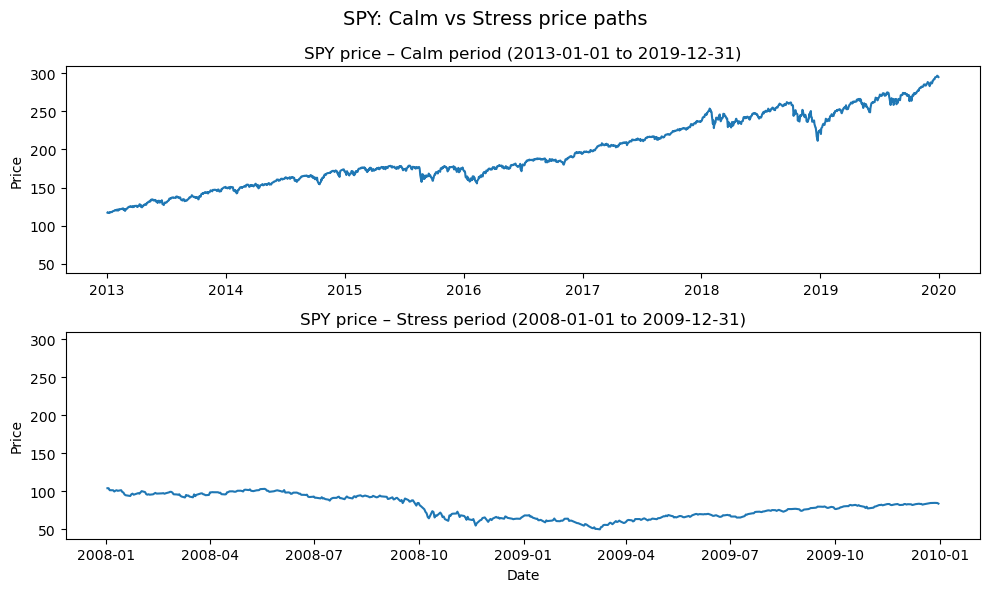

In [20]:
plot_price_two_periods(
    ticker="SPY",
    calm_start="2013-01-01", calm_end="2019-12-31",
    stress_start="2008-01-01", stress_end="2009-12-31"
)


Number of daily returns: 2007


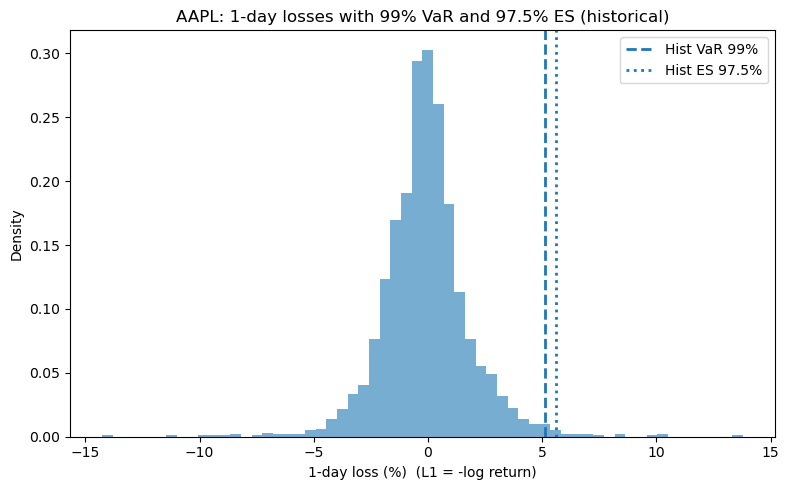


=== 1-DAY VaR & ES (losses on log-return scale) ===

1-day VaR and ES (as % loss of portfolio):
     VaR_hist  ES_hist  VaR_norm  ES_norm   VaR_t    ES_t    df_t
99%    5.1058   7.2089    4.4173   5.0748  5.2736  7.8911  3.2944
97%    3.9276   5.5862    3.7065   4.4396  3.7342  5.7722  3.2944

Number of non-overlapping 10-day returns: 200

=== 10-DAY VaR & ES ===
Historical (non-overlapping 10-day returns) vs Normal with sqrt-of-time scaling

10-day VaR and ES (as % loss of portfolio):
     VaR_hist_10d  ES_hist_10d  VaR_norm_10d_scaled  ES_norm_10d_scaled
99%       17.9651      22.5654              13.3111             15.3902
97%       12.6456      18.3677              11.0632             13.3814

--- Questions for discussion ---
1. Compare 1-day vs 10-day VaR/ES. Does 10-day risk scale roughly with sqrt(10)?
2. Compare historical vs Normal vs Student-t for 1-day. Which one is more conservative?
3. For 10-day, compare historical VaR/ES vs Normal scaled VaR/ES.
   - When is square-roo

In [26]:
"""
Project 2 – Basel-style: 1-day → 10-day VaR & ES from market data

What this script does:
- Downloads 5–10 years of daily prices for a chosen ticker (default: AAPL)
- Computes daily log-returns
- Computes 1-day VaR & ES at 99% and 97.5% using:
    * Historical simulation
    * Parametric Normal
    * Parametric Student-t
- Extends to 10-day horizon:
    * Regulatory style: Normal VaR/ES with square-root-of-time scaling
    * QRM style: historical VaR/ES on non-overlapping 10-day returns
- Plots 1-day loss histogram with historical VaR & ES.

All VaR/ES numbers are reported as **percentage loss** (positive = loss).
"""

import numpy as np
import pandas as pd
from scipy import stats
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


# -----------------------------
# Helpers: data + returns
# -----------------------------

def download_price_data(ticker: str = "AAPL", years: int = 8) -> pd.Series:
    """
    Download adjusted close prices for the given ticker and years of history.
    Uses Yahoo Finance via yfinance.
    Always returns a 1D Series.
    """
    end = datetime.today()
    start = end - timedelta(days=365 * years)

    data = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)

    if data.empty:
        raise ValueError("No price data downloaded. Check ticker or date range.")

    # Prefer Adj Close if present
    if "Adj Close" in data.columns:
        prices = data["Adj Close"]
    else:
        prices = data["Close"]

    # If still a DataFrame (e.g. multiple tickers), use first column
    if isinstance(prices, pd.DataFrame):
        if prices.shape[1] > 1:
            print("Multiple price series detected. Using first column:", prices.columns[0])
        prices = prices.iloc[:, 0]

    prices = prices.dropna()

    if prices.empty:
        raise ValueError("No price data after dropna().")

    return prices


def compute_log_returns(prices: pd.Series) -> pd.Series:
    """
    Compute daily log returns: r_t = ln(P_t / P_{t-1})
    Ensures output is a 1D Series.
    """
    if isinstance(prices, pd.DataFrame):
        if prices.shape[1] > 1:
            print("Multiple price series detected in compute_log_returns. Using first column.")
        prices = prices.iloc[:, 0]

    returns = np.log(prices / prices.shift(1))
    returns = returns.dropna()

    if isinstance(returns, pd.DataFrame):
        returns = returns.iloc[:, 0]

    return returns


# -----------------------------
# Helpers: VaR & ES functions
# -----------------------------

def historical_var_es(losses: pd.Series, alpha: float):
    """
    Historical (empirical) VaR & ES for loss series L (positive = loss).

    VaR_alpha  = empirical alpha-quantile of losses.
    ES_alpha   = mean loss conditional on loss >= VaR_alpha.
    """
    losses = pd.Series(losses).dropna()
    var = losses.quantile(alpha)  # empirical quantile
    es = losses[losses >= var].mean()
    return var, es


def normal_parametric_var_es(losses: pd.Series, alpha: float):
    """
    Parametric Normal VaR & ES for loss series L.

    L ~ N(mu, sigma^2)
    VaR_alpha = mu + z_alpha * sigma
    ES_alpha  = mu + sigma * phi(z_alpha) / (1 - alpha)
    """
    losses = pd.Series(losses).dropna()
    mu = losses.mean()
    sigma = losses.std(ddof=1)
    z = stats.norm.ppf(alpha)

    var = mu + z * sigma
    es = mu + sigma * stats.norm.pdf(z) / (1 - alpha)

    return var, es, mu, sigma


def t_parametric_var_es(losses: pd.Series, alpha: float):
    """
    Parametric Student-t VaR & ES for loss series L.

    Fit L ~ t(df, loc=mu, scale=s).

    VaR_alpha = t_ppf(alpha; df, loc, scale)

    ES_alpha formula for losses L ~ generalized Student-t (df, mu, sigma):
        ES_alpha(L) = mu + sigma * ( (df + t_alpha^2) / (df - 1) ) * tau(t_alpha) / (1 - alpha)

    where t_alpha = standard t-quantile (df),
          tau(.)   = standard t pdf (df).
    """
    losses = pd.Series(losses).dropna()

    # Fit degrees of freedom, location (mu), and scale (sigma)
    df, loc, scale = stats.t.fit(losses)

    # VaR
    var = stats.t.ppf(alpha, df, loc=loc, scale=scale)

    # ES using closed-form formula for t-distribution
    t_alpha = stats.t.ppf(alpha, df)          # standard t quantile
    pdf_t_alpha = stats.t.pdf(t_alpha, df)    # standard t pdf

    es = loc + scale * ( (df + t_alpha**2) / (df - 1) ) * pdf_t_alpha / (1 - alpha)

    return var, es, df, loc, scale


def normal_scaled_var_es(mu1: float, sigma1: float, alpha: float, horizon: int = 10):
    """
    Normal parametric VaR & ES scaled to a longer horizon with square-root-of-time.

    Daily losses: L_1 ~ N(mu1, sigma1^2)
    Horizon H:   L_H = sum_{i=1}^H L_1i ~ N(H * mu1, H * sigma1^2)

    So:
      mu_H    = H * mu1
      sigma_H = sqrt(H) * sigma1

      VaR_H = mu_H + z_alpha * sigma_H
      ES_H  = mu_H + sigma_H * phi(z_alpha) / (1 - alpha)
    """
    z = stats.norm.ppf(alpha)
    mu_h = horizon * mu1
    sigma_h = np.sqrt(horizon) * sigma1

    var_h = mu_h + z * sigma_h
    es_h = mu_h + sigma_h * stats.norm.pdf(z) / (1 - alpha)

    return var_h, es_h


# -----------------------------
# Plot: histogram + VaR & ES
# -----------------------------

def plot_loss_histogram_with_var_es(
    losses: pd.Series,
    alpha_var: float = 0.99,
    alpha_es: float = 0.975,
    title: str = "Daily loss distribution with VaR & ES",
):
    """
    Plot histogram of 1-day losses with historical VaR and ES lines.

    losses   : Series of 1-day losses (L1 = -log returns), positive = loss
    alpha_var: confidence level for VaR (e.g. 0.99)
    alpha_es : confidence level for ES (e.g. 0.975)
    """

    losses = pd.Series(losses).dropna()

    # Historical VaR & ES
    var_hist, _ = historical_var_es(losses, alpha_var)
    _, es_hist = historical_var_es(losses, alpha_es)

    # Convert to % for nicer reading
    losses_pct = losses * 100
    var_pct = var_hist * 100
    es_pct = es_hist * 100

    plt.figure(figsize=(8, 5))
    plt.hist(losses_pct, bins=60, density=True, alpha=0.6)
    plt.axvline(var_pct, linestyle="--", linewidth=2,
                label=f"Hist VaR {int(alpha_var*100)}%")
    plt.axvline(es_pct, linestyle=":", linewidth=2,
                label=f"Hist ES {alpha_es*100:.1f}%")

    plt.xlabel("1-day loss (%)  (L1 = -log return)")
    plt.ylabel("Density")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------------
# Main analysis
# -----------------------------

def main():
    # -------------------------
    # Parameters students can change
    # -------------------------
    TICKER = "AAPL"   # e.g. "AAPL", "SPY", "^STOXX50E"
    YEARS = 8         # use 5–10 years of history

    alphas = [0.99, 0.975]  # 99% (Basel II.5) and 97.5% (FRTB ES level)

    print(f"Downloading data for {TICKER} over the last {YEARS} years...")
    prices = download_price_data(TICKER, YEARS)
    returns = compute_log_returns(prices)

    print(f"Number of daily returns: {len(returns)}")

    # Losses = -returns (positive = loss)
    L1 = -returns

    # -------------------------
    # Plot 1-day loss histogram with VaR & ES
    # -------------------------
    plot_loss_histogram_with_var_es(
        L1,
        alpha_var=0.99,
        alpha_es=0.975,
        title=f"{TICKER}: 1-day losses with 99% VaR and 97.5% ES (historical)",
    )

    # -------------------------
    # 1-day VaR & ES
    # -------------------------
    rows_1d = []
    index_labels = []

    print("\n=== 1-DAY VaR & ES (losses on log-return scale) ===")

    for alpha in alphas:
        label = f"{int(alpha * 100)}%"

        # Historical
        var_hist, es_hist = historical_var_es(L1, alpha)

        # Parametric Normal
        var_norm, es_norm, mu1, sigma1 = normal_parametric_var_es(L1, alpha)

        # Parametric Student-t
        var_t, es_t, df_t, loc_t, scale_t = t_parametric_var_es(L1, alpha)

        rows_1d.append({
            "VaR_hist": var_hist,
            "ES_hist": es_hist,
            "VaR_norm": var_norm,
            "ES_norm": es_norm,
            "VaR_t": var_t,
            "ES_t": es_t,
            "df_t": df_t,
        })
        index_labels.append(label)

    df_1d = pd.DataFrame(rows_1d, index=index_labels)

    # Convert VaR/ES columns to percentages (approx; log-loss ≈ simple-loss for small values)
    risk_cols_1d = ["VaR_hist", "ES_hist", "VaR_norm", "ES_norm", "VaR_t", "ES_t"]
    df_1d_pct = df_1d.copy()
    df_1d_pct[risk_cols_1d] = df_1d_pct[risk_cols_1d] * 100

    print("\n1-day VaR and ES (as % loss of portfolio):")
    print(df_1d_pct.round(4))

    # -------------------------
    # 10-day horizon
    # -------------------------
    # QRM style: build non-overlapping 10-day log-returns
    window = 10
    r_10d = returns.rolling(window=window).sum().dropna()
    r_10d_nonoverlap = r_10d.iloc[::window]  # take every 10th window to avoid overlap
    L10_hist = -r_10d_nonoverlap

    print(f"\nNumber of non-overlapping {window}-day returns: {len(r_10d_nonoverlap)}")

    # Normal scaling: use mu1, sigma1 from DAILY losses
    mu_L1 = L1.mean()
    sigma_L1 = L1.std(ddof=1)

    rows_10d = []

    for alpha in alphas:
        label = f"{int(alpha * 100)}%"

        # Historical 10-day VaR/ES from non-overlapping 10-day losses
        var10_hist, es10_hist = historical_var_es(L10_hist, alpha)

        # Parametric Normal 10-day using square-root-of-time scaling
        var10_norm_scaled, es10_norm_scaled = normal_scaled_var_es(mu_L1, sigma_L1, alpha, horizon=window)

        rows_10d.append({
            "VaR_hist_10d": var10_hist,
            "ES_hist_10d": es10_hist,
            "VaR_norm_10d_scaled": var10_norm_scaled,
            "ES_norm_10d_scaled": es10_norm_scaled,
        })

    df_10d = pd.DataFrame(rows_10d, index=index_labels)

    risk_cols_10d = df_10d.columns.tolist()
    df_10d_pct = df_10d.copy()
    df_10d_pct[risk_cols_10d] = df_10d_pct[risk_cols_10d] * 100

    print("\n=== 10-DAY VaR & ES ===")
    print("Historical (non-overlapping 10-day returns) vs Normal with sqrt-of-time scaling")
    print("\n10-day VaR and ES (as % loss of portfolio):")
    print(df_10d_pct.round(4))

    # -------------------------
    # Extra: quick comparison questions for students (printed hints)
    # -------------------------
    print("\n--- Questions for discussion ---")
    print("1. Compare 1-day vs 10-day VaR/ES. Does 10-day risk scale roughly with sqrt(10)?")
    print("2. Compare historical vs Normal vs Student-t for 1-day. Which one is more conservative?")
    print("3. For 10-day, compare historical VaR/ES vs Normal scaled VaR/ES.")
    print("   - When is square-root-of-time scaling likely to under- or over-estimate risk?")
    print("4. At each confidence level, is ES significantly larger than VaR?")
    print("   - Why might regulators prefer ES over VaR (especially under FRTB)?")


if __name__ == "__main__":
    main()


Path to dataset files: C:\Users\USER\.cache\kagglehub\datasets\toramky\automobile-dataset\versions\2
Using CSV file: C:\Users\USER\.cache\kagglehub\datasets\toramky\automobile-dataset\versions\2\Automobile_data.csv
Columns in dataset: ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
Using last column: price
Number of observations in last column after cleaning: 201
Basic stats:
count      201.000000
mean     13207.129353
std       7947.066342
min       5118.000000
25%       7775.000000
50%      10295.000000
75%      16500.000000
max      45400.000000
Name: price, dtype: float64

=== Empirical (historical) risk measures ===
99% VaR (empirical):    40960.0000
97.5% ES (empirical):   3

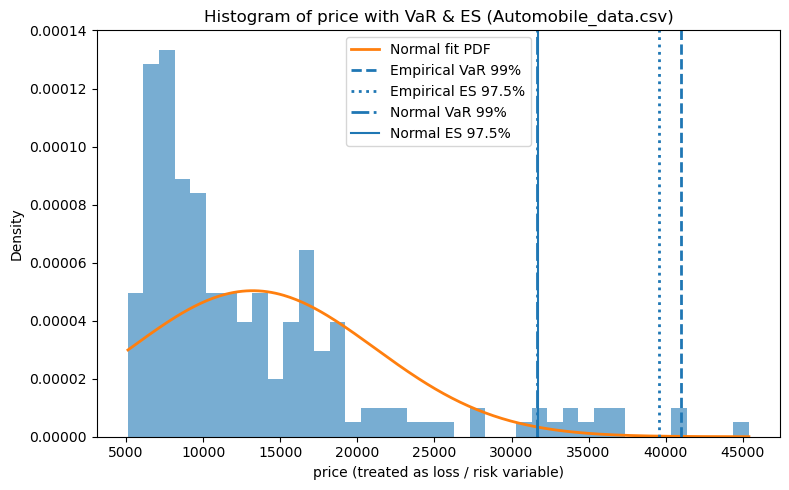

In [30]:
import os
import glob

import kagglehub
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 1. Download dataset and read the CSV
# -------------------------------------------------------------------

# Download latest version of the dataset
path = kagglehub.dataset_download("toramky/automobile-dataset")
print("Path to dataset files:", path)

# Find the first CSV file in the downloaded folder
csv_files = glob.glob(os.path.join(path, "*.csv"))
if not csv_files:
    raise FileNotFoundError("No CSV file found in the downloaded dataset folder.")

csv_path = csv_files[0]
print("Using CSV file:", csv_path)

# Read the CSV
df = pd.read_csv(csv_path)
print("Columns in dataset:", df.columns.tolist())

# -------------------------------------------------------------------
# 2. Select the last column and clean it
# -------------------------------------------------------------------

last_col_name = df.columns[-1]
print("Using last column:", last_col_name)

# Convert to numeric (coerce non-numeric values like '?' to NaN, then drop)
data_raw = df[last_col_name]
data = pd.to_numeric(data_raw, errors="coerce").dropna()

print(f"Number of observations in last column after cleaning: {len(data)}")
print("Basic stats:")
print(data.describe())

# Here we treat this column as a 'loss' variable or generic risk factor.
# If in your context large values are "bad" (losses), this matches VaR intuition.

# -------------------------------------------------------------------
# 3. Functions for empirical (historical) VaR & ES
# -------------------------------------------------------------------

def historical_var_es(series: pd.Series, alpha: float):
    """
    Historical VaR & ES for a 1D numeric series.

    VaR_alpha  = empirical alpha-quantile of the series.
    ES_alpha   = mean of values >= VaR_alpha.
    """
    series = pd.Series(series).dropna()
    var = series.quantile(alpha)
    es = series[series >= var].mean()
    return var, es

# Confidence levels
alpha_var = 0.99   # 99% VaR
alpha_es = 0.975   # 97.5% ES

# -------------------------------------------------------------------
# 4. Empirical VaR & ES (historical)
# -------------------------------------------------------------------

var_emp, es_emp = historical_var_es(data, alpha_var)  # VaR at 99%
_, es_emp_975 = historical_var_es(data, alpha_es)     # ES at 97.5%

print("\n=== Empirical (historical) risk measures ===")
print(f"99% VaR (empirical):    {var_emp:.4f}")
print(f"97.5% ES (empirical):   {es_emp_975:.4f}")

# -------------------------------------------------------------------
# 5. Parametric Normal fit: VaR & ES
# -------------------------------------------------------------------

# Fit Normal distribution to the data
mu, sigma = stats.norm.fit(data)

# Parametric 99% VaR under Normal
var_norm = stats.norm.ppf(alpha_var, loc=mu, scale=sigma)

# Parametric ES at 97.5% under Normal:
# ES_alpha = mu + sigma * phi(z_alpha) / (1 - alpha)
z_es = stats.norm.ppf(alpha_es)
es_norm_975 = mu + sigma * stats.norm.pdf(z_es) / (1 - alpha_es)

print("\n=== Parametric Normal fit risk measures ===")
print(f"99% VaR (Normal fit):   {var_norm:.4f}")
print(f"97.5% ES (Normal fit):  {es_norm_975:.4f}")
print(f"(Fitted mu, sigma) = ({mu:.4f}, {sigma:.4f})")

# -------------------------------------------------------------------
# 6. Plot histogram with empirical & Normal VaR/ES
# -------------------------------------------------------------------

plt.figure(figsize=(8, 5))

# Histogram of the data
plt.hist(data, bins=40, density=True, alpha=0.6)

# Overlay Normal fit PDF
x_vals = np.linspace(data.min(), data.max(), 300)
pdf_norm = stats.norm.pdf(x_vals, loc=mu, scale=sigma)
plt.plot(x_vals, pdf_norm, linewidth=2, label="Normal fit PDF")

# VaR/ES lines (empirical)
plt.axvline(var_emp, linestyle="--", linewidth=2,
            label=f"Empirical VaR {int(alpha_var*100)}%")
plt.axvline(es_emp_975, linestyle=":", linewidth=2,
            label=f"Empirical ES {alpha_es*100:.1f}%")

# VaR/ES lines (Normal fit)
plt.axvline(var_norm, linestyle="-.", linewidth=2,
            label=f"Normal VaR {int(alpha_var*100)}%")
plt.axvline(es_norm_975, linestyle="-", linewidth=1.5,
            label=f"Normal ES {alpha_es*100:.1f}%")

plt.xlabel(f"{last_col_name} (treated as loss / risk variable)")
plt.ylabel("Density")
plt.title(f"Histogram of {last_col_name} with VaR & ES ({os.path.basename(csv_path)})")
plt.legend()
plt.tight_layout()
plt.show()
